In [1081]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score,\
                            confusion_matrix, mean_absolute_error, mean_squared_error, r2_score,\
                            explained_variance_score
from scipy import stats

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

# Laptop Prices

In [1082]:
data = pd.read_csv('laptops.csv', sep=',', encoding='latin-1')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.shape

(1303, 12)

In [1085]:
data['Weight_kg'] = data['Weight'].apply(lambda x: float(x[:-2]))
data['Ram_GB'] = data['Ram'].apply(lambda x: float(x[:-2]))
data.drop(['Weight','Ram'], axis=1,inplace=True)

In [1086]:
def Get_Memory(string_memory, type_memory):
    memory = string_memory.split('+')
    value_memory=0    
    for m in memory:
        index_memory = m.find("GB "+type_memory)
        if index_memory!=-1:
            value_memory = m[:index_memory]
        
    return int(value_memory)

In [1087]:
data['SSD'] = data['Memory'].apply(lambda x: Get_Memory(x, 'SSD'))
data['HDD'] = data['Memory'].apply(lambda x: Get_Memory(x, 'HDD'))
data['Flash'] = data['Memory'].apply(lambda x: Get_Memory(x, 'Flash'))
data.drop('Memory',axis=1,inplace=True)

In [1088]:
def get_screen_resol(screen):
    resolution = screen.split()[-1]    
    width, height = resolution.split('x')     
    return float(width)*float(height)    

In [1089]:
#признак в виде произведения кол.пикселей по высоте на кол.пиксеоей по ширине
data['Resolution'] = data['ScreenResolution'].apply(get_screen_resol)

In [1090]:
def get_ghz(cpu):
    return float(cpu.split()[-1][:-3])

def get_cpu_series(cpu):
    cpu_split = cpu.split()[0:3]
        
    return ' '.join(cpu.split()[0:3])

In [1091]:
data['Cpu_Ghz'] = data['Cpu'].apply(get_ghz)
data['Cpu'] = data['Cpu'].apply(get_cpu_series)
data['Gpu'] = data['Gpu'].apply(get_cpu_series)

In [1092]:
# OneHotEncoding для типа ноутбука
ohe = pd.get_dummies(data['TypeName'])
data = data.join(ohe)

In [1099]:
data = data[data['Price_euros']<4000]

In [1108]:
data['Cpu_company'] = data['Cpu'].apply(lambda x: x.split()[0])

In [1113]:
data['Gpu_'] = data['Gpu'].apply(lambda gpu: gpu.split()[0])

In [1117]:
data.drop(['TypeName','Gpu_','ScreenResolution','Cpu_company'], axis=1,inplace=True)

In [1118]:
ohe = pd.get_dummies(data['OpSys'])
data = data.join(ohe)
data.drop('OpSys',axis=1,inplace=True)

In [1119]:
ohe = pd.get_dummies(data['Cpu'])
data = data.join(ohe)
data.drop('Cpu',axis=1,inplace=True)

In [1120]:
ohe = pd.get_dummies(data['Company'])
data = data.join(ohe)
data.drop('Company',axis=1,inplace=True)

In [1121]:
ohe = pd.get_dummies(data['Product'])
data = data.join(ohe)
data.drop('Product',axis=1,inplace=True)

In [1122]:
ohe = pd.get_dummies(data['Gpu'])
data = data.join(ohe)
data.drop('Gpu',axis=1,inplace=True)

In [1123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1302
Columns: 750 entries, Inches to Nvidia Quadro M620M
dtypes: float64(6), int64(3), uint8(741)
memory usage: 1.1 MB


Все признаки числовые

# Assignment 2

Разбили целевую переменную на два класса по среднему

In [1124]:
data_class = data.drop('Price_euros',axis=1)
target_class = data['Price_euros']>data['Price_euros'].mean()
target_class = target_class.apply(int)

#### 2.1.  Information gain

In [1125]:
def IG(target, index, criterion):
    s_0 = criterion(target)
    s_1 = criterion(target[:index])
    s_2 = criterion(target[index+1:])
    ig = s_0 - len(target[:index])/len(target)*s_1 - len(target[index+1:])/len(target)*s_2  
    return ig

In [1126]:
def gini(data):    
    p = data.sum()[1]/len(data)    
    return 1-p**2-(1-p)**2

In [1127]:
def entropy(data):
    p = data.sum()[1]/len(data)    
    if p==0 or p==1:
        return 0    
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

In [1128]:
#для этих фич посчитаем прирост информации
name_features = ['Notebook','SSD','Ram_GB','Resolution']
name_target = 'Price_euros'

In [1129]:
%%time
def tree_split(data, features, target, criterion):    
    title_plot = ''    
    if criterion == 'entropy':        
        title_plot = criterion
        criterion = entropy
    else:
        title_plot = criterion
        criterion = gini
    
    best_ig = 0
    best_index = 0
    best_feature = ''
    
    for feature in features:        
        ig_by_feature = []        
        for i in range(1, len(data)-1):            
            target_sort_by_feature = data[[feature, target]].sort_values(feature)
            ig = IG(target_sort_by_feature, i, criterion)                        
            ig_by_feature.append(ig)
            
            if ig > best_ig:
                best_ig = ig
                best_index = i
                best_feature = feature
        
        plt.plot(range(len(data) - 2), np.array(ig_by_feature))
        plt.legend(features)
        plt.title(title_plot)
        plt.xlabel('index_value_feature')
        plt.ylabel('information gain')
        plt.grid(True)       
    
    print('Best feature to split:', best_feature)    
    print('Value best feature to split:', data[best_feature][best_index])
    print('Best information gain', round(best_ig,3))

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 13.8 µs


#### 2.2. Information gain(entropy)

Best feature to split: Ram_GB
Value best feature to split: 4.0
Best information gain 0.256


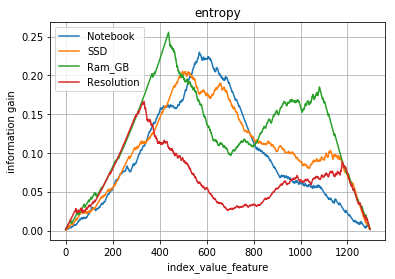

In [1130]:
tree_split(data_class[name_features].join(target_class), name_features, name_target, 'entropy')

#### 2.3. Information gain(Gini index)

Best feature to split: Notebook
Value best feature to split: 0
Best information gain 0.148


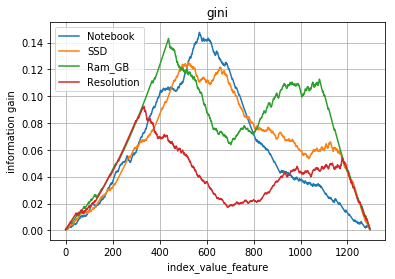

In [1131]:
tree_split(data_class[name_features].join(target_class), name_features, name_target, 'gini')

Разделим выборку на train и test

In [1132]:
X_train, X_test, y_train, y_test = train_test_split(data_class,
                                                    target_class,
                                                    test_size = 0.2,
                                                    random_state=17,
                                                    shuffle=True)

#### 2.4. DecisionTreeClassifier

In [1133]:
tree = DecisionTreeClassifier(random_state=17)

In [1134]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [1135]:
y_pred = tree.predict(X_test)

In [1136]:
accuracy_score(y_test, y_pred)

0.8615384615384616

#### 2.5. GridSearchCV

In [1137]:
tree_params = {'max_depth':np.arange(3,15)}

In [1138]:
tree = DecisionTreeClassifier(random_state=17)

In [1139]:
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1)

In [1140]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [1141]:
tree_grid.best_score_, tree_grid.best_params_

(0.8671799807507219, {'max_depth': 14})

In [1142]:
pred_tree_gridcv = tree_grid.best_estimator_.predict(X_test)

In [1143]:
accuracy_score(y_test, pred_tree_gridcv)

0.8653846153846154

Немного увеличилось accuracy

#### 2.6. Display final tree as an image 

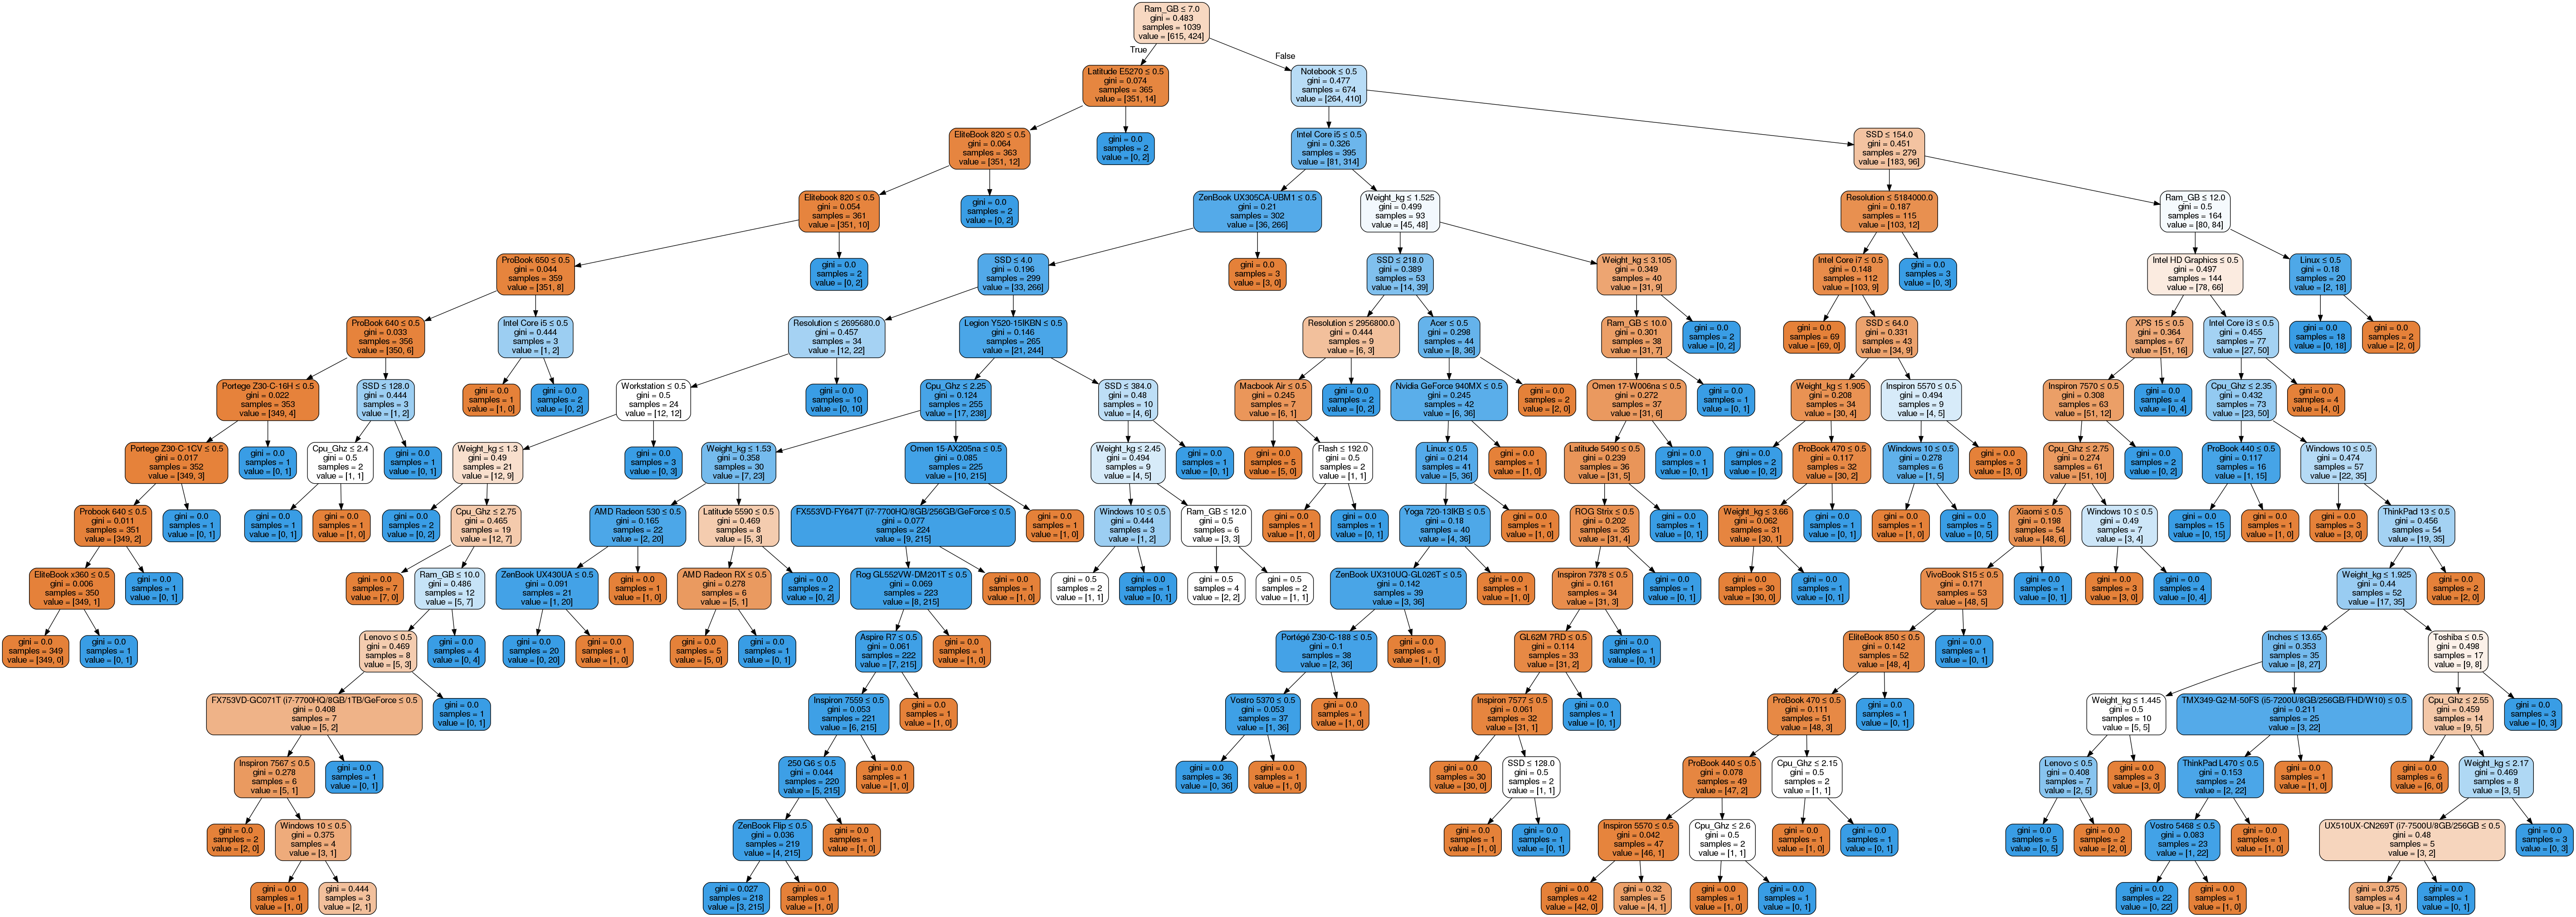

In [1144]:
from ipywidgets import Image
from io import StringIO
import pydot 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_grid.best_estimator_,feature_names=data_class.columns, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [1145]:
print('Важность признаков')
for i, feat in enumerate(data_class.columns):
    if tree_grid.best_estimator_.feature_importances_[i] >= 0.05:
        print(feat, tree_grid.best_estimator_.feature_importances_[i])

Важность признаков
Weight_kg 0.06180725639503079
Ram_GB 0.3366180782360298
SSD 0.07164630205956478
Notebook 0.13632610941925646


# Assignment 3

In [1146]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [1147]:
scalar = StandardScaler()

X_train_scale_class = scalar.fit_transform(X_train)
X_test_scale_class = scalar.transform(X_test)

y_train_class = y_train
y_test_class = y_test

In [1148]:
estimators = []

#### 3.1. BaggingClassifier

In [1149]:
# base estimator is a decision tree
bcl = BaggingClassifier().fit(X_train_scale_class, y_train_class)
bcl_pred = bcl.predict(X_test_scale_class)
estimators.append(('bcl',bcl))

#### 3.2. RandomForestClassifier

In [1150]:
rfc = RandomForestClassifier().fit(X_train_scale_class, y_train_class)
rfc_pred = rfc.predict(X_test_scale_class)
estimators.append(('rfc', rfc))

#### 3.3. LogisticRegression

In [1151]:
lr = LogisticRegression().fit(X_train_scale_class,y_train_class)
lr_pred = lr.predict(X_test_scale_class)
estimators.append(('lr',lr))

#### 3.4. KNeighborsClassifier

In [1152]:
knn = KNeighborsClassifier().fit(X_train_scale_class, y_train_class)
knn_pred = knn.predict(X_test_scale_class)
estimators.append(('knn',knn))

#### 3.5. Compare models accuracy

In [1153]:
print('BaggingClassifier acc =',accuracy_score(y_test_class, bcl_pred))
print('RandomForestClassifier acc =',accuracy_score(y_test_class, rfc_pred))
print('LogisticRegression acc =',accuracy_score(y_test_class, lr_pred))
print('KNeighborsClassifier acc =',accuracy_score(y_test_class, knn_pred))

BaggingClassifier acc = 0.8576923076923076
RandomForestClassifier acc = 0.8807692307692307
LogisticRegression acc = 0.9076923076923077
KNeighborsClassifier acc = 0.8038461538461539


#### 3.6. Ensemble of models 

In [1154]:
vc = VotingClassifier(estimators=estimators)
vc.fit(X_train_scale_class, y_train_class)

VotingClassifier(estimators=[('bcl', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)), ('rfc', RandomForestClassifier(bootstrap...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [1155]:
vc_pred = vc.predict(X_test_scale_class)

#### 3.7. Different accuracy metrics

In [1156]:
accuracy_score(y_test_class, vc_pred)

0.8807692307692307

In [1157]:
roc_auc_score(y_test_class, vc_pred)

0.8724137931034482

In [1158]:
recall_score(y_test_class, vc_pred)

0.8

In [1159]:
precision_score(y_test_class, vc_pred)

0.92

In [1160]:
confusion_matrix(y_test_class, vc_pred)

array([[137,   8],
       [ 23,  92]])